Assignment 13

In [1]:
!pip install vit-pytorch linformer

In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from linformer import Linformer   
import glob   
from PIL import Image
from itertools import chain   
from vit_pytorch.efficient import ViT   
from tqdm.notebook import tqdm   
from __future__ import print_function

import torch   
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms   
from torch.optim.lr_scheduler import StepLR   
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split   

import zipfile   

Let's start by downloading our data, a .zip of JPG pictures of cats and dogs, and extracting it locally in `/tmp`.

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2021-08-05 04:05:35--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.128, 74.125.137.128, 142.250.141.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   279MB/s    in 0.2s    

2021-08-05 04:05:35 (279 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [4]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

The contents of the .zip are extracted to the base directory `/tmp/cats_and_dogs_filtered`, which contains `train` and `validation` subdirectories for the training and validation datasets. Let's define each of these directories:

In [5]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

Now, let's see what the filenames look like in the `cats` and `dogs` `train` directories.

In [6]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.916.jpg', 'cat.815.jpg', 'cat.365.jpg', 'cat.787.jpg', 'cat.521.jpg', 'cat.623.jpg', 'cat.272.jpg', 'cat.542.jpg', 'cat.256.jpg', 'cat.941.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


Let's find out the total number of cat and dog images in the `train` and `validation` directories:

In [7]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


For both cats and dogs, we have 1,000 training images and 500 test images.

Now let's take a look at a few pictures to get a better sense of what the cat and dog datasets look like. First, configure the matplot parameters:

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Now, display a batch of 8 cat and 8 dog pictures.

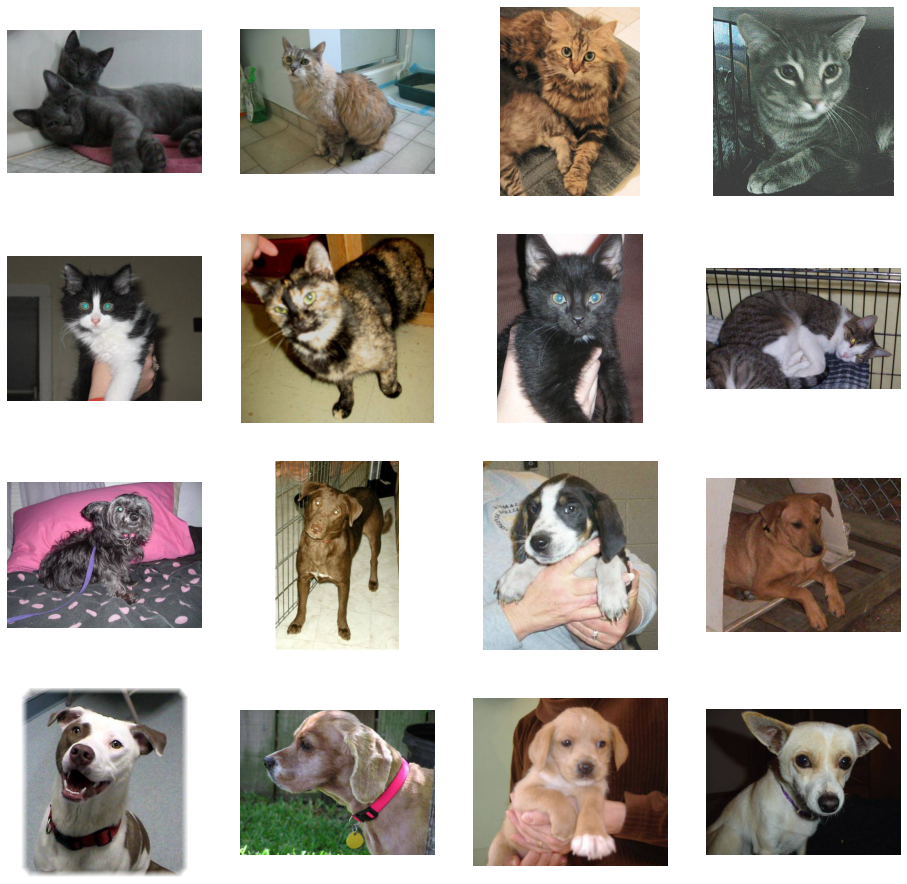

In [9]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


In [10]:
batch_size = 64
epochs = 20
lr = 3e-5
gamma = 0.7 #for learning rate scheduler 

In [18]:
train_dir = '/tmp/cats_and_dogs_filtered/train'
test_dir = '/tmp/cats_and_dogs_filtered/validation'

train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

#printing length of the dataset

print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 0
Test Data: 0


In [17]:
os.listdir("/tmp/cats_and_dogs_filtered/")

['train', 'vectorize.py', 'validation']

In [19]:
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5],
                             [0.5, 0.5, 0.5])
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5],
                             [0.5, 0.5, 0.5])
    ])
}

In [25]:
train_dataset = datasets.ImageFolder(root = train_dir,
                                      transform = image_transforms["train"]
                                     )
test_dataset = datasets.ImageFolder(root = test_dir,
                                      transform = image_transforms["test"]
                                     )

train_loader = DataLoader(dataset = train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_dataset, batch_size=batch_size, shuffle=True)

In [26]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=2,
    transformer=efficient_transformer,
    channels=3,
).to(device)

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [34]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean() * 100
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f}%\n"
    )

Epoch : 1 - loss : 0.6477 - acc: 61.7188%

Epoch : 2 - loss : 0.6313 - acc: 63.8184%

Epoch : 3 - loss : 0.6260 - acc: 65.2344%

Epoch : 4 - loss : 0.6139 - acc: 66.3574%

Epoch : 5 - loss : 0.5955 - acc: 67.4316%

Epoch : 6 - loss : 0.5896 - acc: 68.5059%

Epoch : 7 - loss : 0.5715 - acc: 69.4336%

Epoch : 8 - loss : 0.5639 - acc: 70.4102%

Epoch : 9 - loss : 0.5449 - acc: 71.7285%

Epoch : 10 - loss : 0.5156 - acc: 73.9746%

Epoch : 11 - loss : 0.4878 - acc: 76.2695%

Epoch : 12 - loss : 0.4556 - acc: 77.9297%

Epoch : 13 - loss : 0.4675 - acc: 76.9043%

Epoch : 14 - loss : 0.4174 - acc: 81.1523%

Epoch : 15 - loss : 0.3687 - acc: 83.4961%

Epoch : 16 - loss : 0.3392 - acc: 85.4492%

Epoch : 17 - loss : 0.3130 - acc: 86.1816%

Epoch : 18 - loss : 0.2587 - acc: 89.5508%

Epoch : 19 - loss : 0.2312 - acc: 90.4785%

Epoch : 20 - loss : 0.1870 - acc: 93.4082%

